In [188]:
import pandas as pd

from tensorflow import keras
from keras import layers

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


In [189]:
df['Cabin'].dropna().head()
func = lambda x: x[0]
puk = df['Cabin'].apply(str).apply(func)
puk.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [190]:
func = lambda x: x[0]
for dataf in [df, df_test]:
    minor = dataf['Age'] < 11
    adult = dataf['Age'] >= 11
    dataf.loc[minor, 'Age'] = 'minor'
    dataf.loc[adult, 'Age'] = 'adult'
    dataf['Age'].fillna('missing', inplace=True)
    dataf['relatives'] = dataf['SibSp'] + dataf['Parch']
    alone = dataf['relatives'] == 0
    survivor = (dataf['relatives'] > 0)
    dataf.loc[alone, 'relatives'] = 'alone'
    dataf.loc[survivor, 'relatives'] = 'survivor'
    dataf["Embarked"].fillna('S', inplace=True)
    dataf['Cabin'] = dataf['Cabin'].apply(str).apply(func)

In [191]:
y = df.pop('Survived')

In [202]:
X = df.drop(['Ticket', 'Name', 'SibSp', 'Parch', 'PassengerId'], axis=1)
X_test = df_test.drop(['Ticket', 'Name', 'SibSp', 'Parch', 'PassengerId'], axis=1)

In [203]:
X['Cabin'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [204]:
cat_features = ['Pclass', 'Sex', 'Embarked', \
                'Age', 'relatives', 'Cabin']
num_features = ['Fare']

In [205]:
X_test['Fare'].fillna(X_test['Fare'].median(), inplace=True)

In [206]:
mask = [True if 'T' in item else False for item in X['Cabin'].apply(str)]
X.loc[mask, 'Cabin'] = 'n'

In [207]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def keras_classifier_wrapper():
    clf = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, input_shape=[22], activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return clf

train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, random_state=11)

scaler = StandardScaler()
encoder = OneHotEncoder()

clf = keras_classifier_wrapper()

preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, num_features),
    ('cat', encoder, cat_features)
])

train_X = pd.DataFrame(preprocessor.fit_transform(train_X))
train_X.columns = preprocessor.get_feature_names_out()
test_X = pd.DataFrame(preprocessor.transform(test_X))
test_X.columns = preprocessor.get_feature_names_out()
X_test = pd.DataFrame(preprocessor.transform(X_test))
X_test.columns = preprocessor.get_feature_names_out()
test_X.shape

(223, 22)

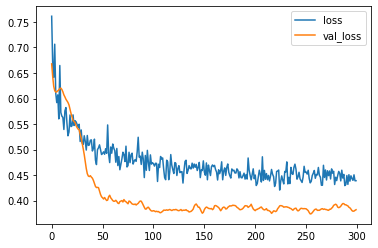

In [208]:
history = clf.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=128,
    epochs=300,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [199]:
predictions = clf.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [200]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test['PassengerId']
submission['Survived'] = pd.DataFrame(predictions.round())
submission['Survived'] = submission['Survived'].apply(int)
submission.to_csv('nn_third_try.csv', index=False)

In [201]:
submission['Survived'].sum()

120